In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plot_tools as pt
import analysis_data as ad

In [ ]:
#该代码用于PMT标定

# f='runlist/tpc_4pmt_darkrate_20250614_run2_processed'
f='runlist/tpc_4pmt_led_20250617_run1_processed'
# f='runlist/tpc_4pmt_led_20250617_round3_run0_processed'
# f='runlist/tpc_4pmt_darkrate_20250617_round3_run0_processed'


flist = ad.read_file_names(f)
df = ad.merge_files(flist)
# df = df[df.Ch == 1]
df.head()
#这里读取了文件并保存为DataFrame格式。然后df.head()会输出一些相关信息，包括事件序号，channel，TTT等。

outnpy/r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0.h5py


,Ch,TTT,Baseline,STD,Area,Hight,Width,st,ed,md,WLen,RFOvhight,RunType,Ftag,Wave,BaselineArea
0,0,233816,15182,2.009975,201,145,5,108,113,109,200,-6,DarkRate,r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0,"[15185, 15182, 15183, 15185, 15181, 15185, 151...",-69
1,1,233816,15317,2.586503,-1,5,5,53,58,55,200,-6,DarkRate,r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0,"[15319, 15315, 15314, 15317, 15319, 15316, 153...",-98
2,3,233816,15243,2.416609,15,10,6,49,55,51,200,-3,DarkRate,r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0,"[15239, 15235, 15242, 15242, 15240, 15240, 152...",79
3,2,233816,15149,3.324154,-3,6,4,1,5,2,200,-6,DarkRate,r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0,"[15150, 15150, 15143, 15152, 15153, 15155, 151...",-31
4,0,483812,15182,3.106445,112,62,5,111,116,112,200,-7,DarkRate,r8520_4pmt_tpc_led_20250617_run1_raw_b0_seg0,"[15181, 15188, 15183, 15176, 15179, 15181, 151...",-49


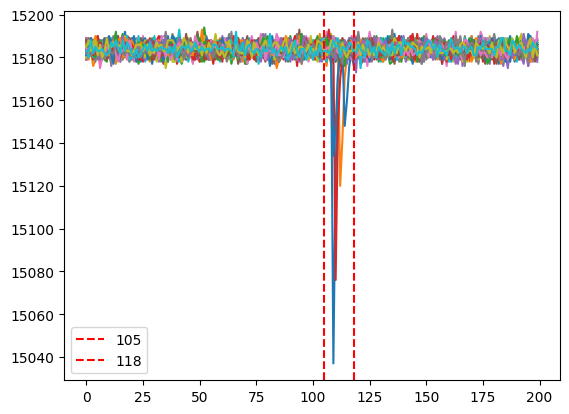

In [ ]:
#波形
lowerbound = 105
upperbound = 118
for i in range(50):
    plt.plot(df[df.Ch == 0]["Wave"].values[i][0:1000])
plt.axvline(lowerbound, color='red', linestyle='--', label=f'{lowerbound}')
plt.axvline(upperbound, color='red', linestyle='--', label=f'{upperbound}')
plt.legend()
plt.show()
#然后我们可以根据事件序号看对应的波形,因为外触发模式下积分的时间窗口是不定的，可能需要手动修改
# bin2h5df_selftrigrun.py 代码中的process_batch函数中的area部分
#在正确地修改好积分时间窗口后，需要重新运行bin2h5df_selftrigrun.py来得到正确的峰面积。

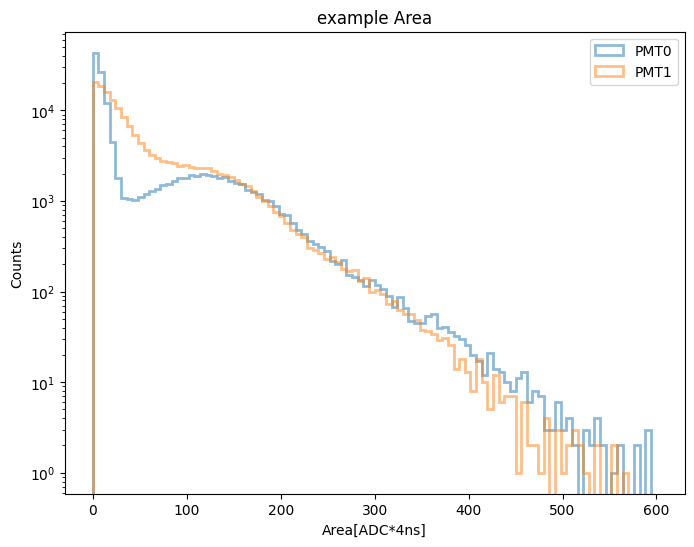

In [ ]:
#这里可以看峰高，峰面积等的统计分布
channels = [0,1]
attribute = 'Area'
plt.figure(figsize=(8, 6))
for ch in channels:
    df_ch = df[df.Ch == ch]
    plt.hist(df_ch[f'{attribute}'], bins=100, range=(0,600), alpha=0.5, label=f'Ch{ch}',histtype='step', lw=2)
plt.xlabel(f'{attribute}[ADC*4ns]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend('PMT0 PMT1 PMT2 PMT3'.split())
plt.title(f'example {attribute}')
plt.show()

In [71]:
#多高斯拟合
from lmfit import Model, Parameters

def multi_gaussian_fit_plot(data, n_PE=2, channel=0, bins=100, area_range=(-200, 1000)):
    """
    data: 一维数据（如df.Area）
    n_PE: 0~3，表示拟合到几光子峰
    channel: int，指定通道号
    bins: 直方图bin数
    area_range: 直方图范围
    注意！！！拟合所用初始值与范围会严重影响拟合结果，尤其是多光子拟合，建议根据实际数据调整初始值，可以先用单光子的结果确定 mu1, sigma1 等参数！！！
    在 limit部分改变初始值和范围，确保拟合结果合理。
    """
    # 动态构造高斯叠加函数
    data = df[df.Ch == channel].Area
    channel_label = f'Channel {channel}'

    def gauss_sum(x, A0, mu0, sigma0, A1=0, mu1=0, sigma1=1, A2=0, A3=0):
        y = A0 * np.exp(-(x - mu0)**2 / (2 * sigma0**2))
        if n_PE >= 1:
            y += A1 * np.exp(-(x - mu1 - mu0)**2 / (2 * (sigma1**2 + sigma0**2)))
        if n_PE >= 2:
            mu2 = 2*mu1 - mu0
            sigma2 = np.sqrt(2*sigma1**2 + sigma0**2)
            y += A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
        if n_PE >= 3:
            mu3 = 3*mu1 - mu0
            sigma3 = np.sqrt(3*sigma1**2 + sigma0**2)
            y += A3 * np.exp(-(x - mu3)**2 / (2 * sigma3**2))
        return y

    # 直方图
    counts, bins_ = np.histogram(data, bins=bins, range=area_range)
    bin_centers = (bins_[:-1] + bins_[1:]) / 2

    # lmfit参数
    model = Model(gauss_sum)
    params = Parameters()
    params.add('A0', value=counts.max()/2, min=1, max=1e7)
    params.add('mu0', value=0, min=-30, max=30)
    params.add('sigma0', value=30, min=1, max=100)
    params.add('A1', value=counts.max()/4, min=1, max=1e6)
    params.add('mu1', value=100, min=40, max=200)
    params.add('sigma1', value=30, min=10, max=200)
    params.add('A2', value=counts.max()/8 if n_PE>=1 else 0, min=0, max=1e5)
    params.add('A3', value=counts.max()/16 if n_PE>=2 else 0, min=0, max=1e4)

    # 拟合
    result = model.fit(counts, params, x=bin_centers)
    best = result.best_values

    # 拟合参数提取
    A0, mu0, sigma0 = best['A0'], best['mu0'], best['sigma0']
    if n_PE >= 1:
        A1, mu1, sigma1 = best['A1'], best['mu1'], best['sigma1']
    if n_PE >= 2:
        A2 = best['A2']
        mu2 = 2*mu1 - mu0
        sigma2 = np.sqrt(2*sigma1**2 + sigma0**2)
    if n_PE >= 3:
        A3 = best['A3']
        mu3 = 3*mu1 - mu0
        sigma3 = np.sqrt(3*sigma1**2 + sigma0**2)
    x_fit = np.linspace(area_range[0], area_range[1], 500)

    # 作图
    plt.figure(figsize=(8,6))
    plt.hist(data, bins=bins, range=area_range, alpha=0.5, label='Data', histtype='step', lw=2)

    plt.plot(x_fit, gauss_sum(x_fit, **{k:best.get(k,0) for k in model.param_names}), 'r-', label='Total Fit')

    # 各分量虚线
    plt.plot(x_fit, A0 * np.exp(-((x_fit - mu0) ** 2) / (2 * sigma0 ** 2)), 'k--', label='Pedestal')
    if n_PE >= 1:
        plt.plot(x_fit, A1 * np.exp(-((x_fit - mu1 - mu0) ** 2) / (2 * (sigma1**2 + sigma0**2))), 'b--', label= f'$\mu_{{SPE}}$={mu1:.2f}, $\sigma$={sigma1:.2f}')
    if n_PE >= 2:
        plt.plot(x_fit, A2 * np.exp(-((x_fit - mu2) ** 2) / (2 * sigma2 ** 2)), 'g--', label=f'$\mu_{{DPE}}$={mu2:.2f}, $\sigma_{{DPE}}$={sigma2:.2f}')
    if n_PE >= 3:
        plt.plot(x_fit, A3 * np.exp(-((x_fit - mu3) ** 2) / (2 * sigma3 ** 2)), 'y--', label=f'$\mu_{{TPE}}$={mu3:.2f}, $\sigma_{{TPE}}$={sigma3:.2f}')
    
    factor = (2/(2**14))*4e-9/(50*1.6e-19*1e6) #转换因子，将ADC*4ns变成以10^6 PE为单位

    plt.xlabel('Area[ADC*4ns]')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(1, counts.max()*1.2)
    plt.axvline((mu1+mu0), color='purple', ls='--',label=f'SPE gain={(mu1+mu0)*factor:.2f} 10⁶ PE')
    plt.legend()
    plt.title(f'{channel_label} Area {n_PE}-PE Fit')
    plt.show()
    print(result.fit_report())


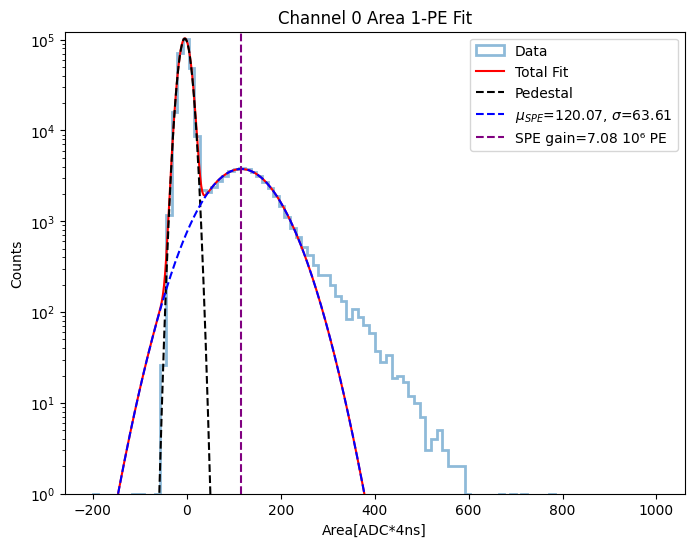

[[Model]]
    Model(gauss_sum)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 100
    # variables        = 8
    chi-square         = 462379.959
    reduced chi-square = 5025.86912
    Akaike info crit   = 859.897207
    Bayesian info crit = 880.738568
    R-squared          = 0.99997317
##  Warning: uncertainties could not be estimated:
    A2:      at initial value
    A3:      at boundary
[[Variables]]
    A0:      102719.964 (init = 50816)
    mu0:    -4.11431725 (init = 0)
    sigma0:  11.3117747 (init = 30)
    A1:      3757.96783 (init = 25408)
    mu1:     120.074033 (init = 100)
    sigma1:  63.6110724 (init = 30)
    A2:      12704.0000 (init = 12704)
    A3:      0.00000000 (init = 0)


In [75]:
# 只需传入数据和n_PE参数即可
multi_gaussian_fit_plot(df.Area, n_PE=1, channel=0)

In [76]:
#计算增益gain以1e6 PE 为单位       
mu=8.8
mu*(2/(2**14))*4e-9/(50*1.6e-19*1e6) 

0.5371093750000001